<a href="https://colab.research.google.com/github/schradern/datathon_2026/blob/main/Copy_of_01_weaning_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites

Change PROJECT_ID to your own project ID.

In [89]:
PROJECT_ID = "" #@param {type:"string"}

# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'van_gogh_2026_datathon' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

In [90]:
import os
from google.colab import auth
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
auth.authenticate_user()
print('Authenticated')

Authenticated


In [91]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# change default limits:
DataTable.max_columns = 50
DataTable.max_rows = 30000

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [92]:
from google.cloud import bigquery
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
client = bigquery.Client(project=PROJECT_ID, location=LOCATION)

from google.cloud.bigquery import magics
magics.context.default_query_job_config = def_config

In [93]:
import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt
import numpy as np

config_gbq = {
    "query": {
        "defaultDataset": {"projectId": DATASET_PROJECT_ID, "datasetId": DATASET_ID},
        "location": LOCATION,
    }
}

src_config = f"{DATASET_PROJECT_ID}.{DATASET_ID}"

def q(sql: str) -> pd.DataFrame:
    return pandas_gbq.read_gbq(
        sql,
        project_id=PROJECT_ID,
        configuration=config_gbq,
        use_bqstorage_api=True,
    )

## Cohort / Weaning identification

### definitions

In [94]:
# core settings
MV_CORE = {
    3022875: 'peep_set',
    3012410: 'tv_set',
    3025408: 'fio2_vent',
    3007469: 'rr_set'
}

# airway
AIRWAY = {
    2000000629: 'ett_depth',
    21491186: 'ett_diameter',
    36305611: 'trach_diameter'
}

# ventilation settings
MV_EXTENDED = {
    3000461: 'ps_set',
    2000000209: 'pinsp_above_peep',
    3045410: 'minute_vol_set',
    36304672: 'insp_time_set'
}

# ventilation measured
MV_MEASURED = {
    3016226: 'peep_meas',
    2000000238: 'peak_pressure',
    21490854: 'tv_meas'
}

# niv
NIV = {
    2000000188: 'bipap_high',
    2000000191: 'bipap_low',
    2000000203: 'fio2_niv'
}

# oxygen
O2_THERAPY = {
    42868484: 'o2_device',
    3005629: 'o2_flow'
}

# Blood gas analysis
BGA = {
    3027801: 'pao2',
    3027946: 'paco2',
    3019977: 'ph',
    3016502: 'sao2'
}

# vitals
VITALS = {
    40762499: 'spo2',
    3027018: 'hr',
    3004249: 'rr'
}

ALL_CONCEPTS = {**MV_CORE, **AIRWAY, **MV_EXTENDED, **MV_MEASURED,
                **NIV, **O2_THERAPY, **BGA, **VITALS}

## Extraction

In [95]:

QUERY_WEANING_FEATURES = f"""
WITH ventilated AS (
  SELECT DISTINCT person_id
  FROM `{src_config}.measurement`
  WHERE measurement_datetime IS NOT NULL
    AND value_as_number IS NOT NULL
    AND measurement_concept_id IN (3022875, 3012410, 3025408, 3007469)
),

hourly_raw AS (
  SELECT
    m.person_id,
    TIMESTAMP_TRUNC(TIMESTAMP(m.measurement_datetime), HOUR) AS ts_hr,
    m.measurement_concept_id AS cid,
    AVG(m.value_as_number) AS val
  FROM `{src_config}.measurement` m
  INNER JOIN ventilated v USING (person_id)
  WHERE m.measurement_datetime IS NOT NULL
    AND m.value_as_number IS NOT NULL
  GROUP BY person_id, ts_hr, cid
),

hourly_vent AS (
  SELECT
    person_id,
    ts_hr,

    -- Vent settings
    MAX(IF(cid = 3022875, val, NULL)) AS peep_set,
    MAX(IF(cid = 3012410, val, NULL)) AS tv_set,
    MAX(IF(cid = 3007469, val, NULL)) AS rr_set,

    -- FiO2 (normalized to 0-1)
    MAX(IF(cid = 3025408,
      CASE WHEN val > 1.5 THEN val/100
           WHEN val BETWEEN 0.05 AND 1.0 THEN val
           ELSE NULL END,
      NULL)) AS fio2,

    -- Airway markers
    COALESCE(
      MAX(IF(cid = 2000000629, val, NULL)),
      MAX(IF(cid = 21491186, val, NULL)),
      MAX(IF(cid = 36305611, val, NULL))
    ) AS airway_marker,

    -- O2 flow
    MAX(IF(cid = 3005629, val, NULL)) AS o2_flow,

    -- NIV markers
    COALESCE(
      MAX(IF(cid = 2000000188, val, NULL)),
      MAX(IF(cid = 2000000191, val, NULL))
    ) AS niv_marker,

    -- "BGA"/gas values
    MAX(IF(cid = 3027801, val, NULL)) AS pao2,
    MAX(IF(cid = 3027946, val, NULL)) AS paco2,
    MAX(IF(cid = 3019977, val, NULL)) AS ph,
    MAX(IF(cid = 3016502,
      CASE WHEN val > 1.5 THEN val/100
           WHEN val BETWEEN 0.05 AND 1.0 THEN val
           ELSE NULL END,
      NULL)) AS sao2

  FROM hourly_raw
  GROUP BY person_id, ts_hr
),

classified AS (
  SELECT
    *,
    CASE
      WHEN peep_set IS NOT NULL AND airway_marker IS NOT NULL THEN 'INV_MV'
      WHEN niv_marker IS NOT NULL THEN 'NIV'
      WHEN o2_flow >= 30 THEN 'HFNC'
      WHEN o2_flow > 0 THEN 'O2'
      WHEN o2_flow = 0 THEN 'RA'
      WHEN o2_flow IS NULL AND peep_set IS NULL AND airway_marker IS NULL AND niv_marker IS NULL THEN 'RA'
      ELSE 'UNKNOWN'
    END AS support_type
  FROM hourly_vent
),

with_changes AS (
  SELECT
    *,
    LAG(support_type) OVER (PARTITION BY person_id ORDER BY ts_hr) AS prev_type,
    LAG(ts_hr) OVER (PARTITION BY person_id ORDER BY ts_hr) AS prev_ts,
    TIMESTAMP_DIFF(ts_hr, LAG(ts_hr) OVER (PARTITION BY person_id ORDER BY ts_hr), HOUR) AS gap_h
  FROM classified
  WHERE support_type != 'UNKNOWN'
),

with_periods AS (
  SELECT
    *,
    SUM(
      CASE
        WHEN prev_type IS NULL OR prev_type != support_type OR gap_h > 6 THEN 1
        ELSE 0
      END
    ) OVER (PARTITION BY person_id ORDER BY ts_hr) AS period_id
  FROM with_changes
),

vent_periods AS (
  SELECT
    person_id,
    period_id,
    support_type,
    MIN(ts_hr) AS start,
    MAX(ts_hr) AS end_ts,
    COUNT(*) AS n_hours,
    TIMESTAMP_DIFF(MAX(ts_hr), MIN(ts_hr), HOUR) + 1 AS duration_h,

    AVG(peep_set) AS peep_mean,
    AVG(tv_set) AS tv_mean,
    AVG(fio2) AS fio2_mean,
    AVG(rr_set) AS rr_mean,
    AVG(o2_flow) AS o2_flow_mean
  FROM with_periods
  GROUP BY person_id, period_id, support_type
),

periods_w_next AS (
  SELECT
    p.*,
    LEAD(start) OVER (PARTITION BY person_id ORDER BY start) AS next_start,
    LEAD(support_type) OVER (PARTITION BY person_id ORDER BY start) AS next_type,
    LEAD(duration_h) OVER (PARTITION BY person_id ORDER BY start) AS next_duration_h
  FROM vent_periods p
),

attempts AS (
  SELECT
    person_id,
    period_id,
    start AS inv_start,
    next_start AS wean_time,
    next_type AS post_support,
    TIMESTAMP_DIFF(next_start, end_ts, HOUR) AS gap_h,

    duration_h,
    n_hours,
    peep_mean,
    tv_mean,
    fio2_mean,
    rr_mean
  FROM periods_w_next
  WHERE support_type = 'INV_MV'
    AND next_type IN ('NIV', 'HFNC', 'O2', 'RA')
    AND TIMESTAMP_DIFF(next_start, end_ts, HOUR) BETWEEN 1 AND 12
    AND duration_h >= 2
    AND next_duration_h >= 2
),

returns AS (
  SELECT
    a.person_id,
    a.period_id,
    MIN(p.start) AS return_time
  FROM attempts a
  INNER JOIN vent_periods p
    ON p.person_id = a.person_id
    AND p.support_type = 'INV_MV'
    AND p.start > a.wean_time
    AND p.start <= TIMESTAMP_ADD(a.wean_time, INTERVAL 48 HOUR)
    AND p.duration_h >= 2
  GROUP BY a.person_id, a.period_id
),

death_48h AS (
  SELECT
    a.person_id,
    a.period_id,
    CASE
      WHEN d.death_datetime IS NOT NULL THEN TIMESTAMP(d.death_datetime)
      WHEN d.death_date IS NOT NULL THEN TIMESTAMP(DATETIME(d.death_date, TIME '12:00:00'))
      ELSE NULL
    END AS death_time
  FROM attempts a
  LEFT JOIN `{src_config}.death` d
    ON d.person_id = a.person_id
  WHERE (
      CASE
        WHEN d.death_datetime IS NOT NULL THEN TIMESTAMP(d.death_datetime)
        WHEN d.death_date IS NOT NULL THEN TIMESTAMP(DATETIME(d.death_date, TIME '12:00:00'))
        ELSE NULL
      END
    ) IS NOT NULL
    AND (
      CASE
        WHEN d.death_datetime IS NOT NULL THEN TIMESTAMP(d.death_datetime)
        WHEN d.death_date IS NOT NULL THEN TIMESTAMP(DATETIME(d.death_date, TIME '12:00:00'))
        ELSE NULL
      END
    ) BETWEEN a.wean_time AND TIMESTAMP_ADD(a.wean_time, INTERVAL 48 HOUR)
),

labeled AS (
  SELECT
    a.*,
    CASE WHEN r.return_time IS NOT NULL THEN 1 ELSE 0 END AS reintub_48h,
    CASE WHEN d.death_time IS NOT NULL THEN 1 ELSE 0 END AS death_48h,
    CASE WHEN (r.return_time IS NOT NULL OR d.death_time IS NOT NULL) THEN 1 ELSE 0 END AS failure_48h,

    (SELECT ARRAY_AGG(t ORDER BY t LIMIT 1)[SAFE_OFFSET(0)]
     FROM UNNEST([r.return_time, d.death_time]) AS t
     WHERE t IS NOT NULL) AS failure_time,

    TIMESTAMP_DIFF(
      (SELECT ARRAY_AGG(t ORDER BY t LIMIT 1)[SAFE_OFFSET(0)]
       FROM UNNEST([r.return_time, d.death_time]) AS t
       WHERE t IS NOT NULL),
      a.wean_time,
      MINUTE
    ) / 60.0 AS time_to_failure_h
  FROM attempts a
  LEFT JOIN returns r USING (person_id, period_id)
  LEFT JOIN death_48h d USING (person_id, period_id)
),

bga AS (
  SELECT
    l.person_id,
    l.period_id,

    ARRAY_AGG(h.pao2  IGNORE NULLS ORDER BY h.ts_hr DESC LIMIT 1)[SAFE_OFFSET(0)] AS pao2_prewean,
    ARRAY_AGG(h.paco2 IGNORE NULLS ORDER BY h.ts_hr DESC LIMIT 1)[SAFE_OFFSET(0)] AS paco2_prewean,
    ARRAY_AGG(h.ph    IGNORE NULLS ORDER BY h.ts_hr DESC LIMIT 1)[SAFE_OFFSET(0)] AS ph_prewean,
    ARRAY_AGG(h.sao2  IGNORE NULLS ORDER BY h.ts_hr DESC LIMIT 1)[SAFE_OFFSET(0)] AS sao2_prewean,

    MAX(IF(h.pao2 IS NOT NULL OR h.paco2 IS NOT NULL, 1, 0)) AS has_abg_core_prewean,
    MAX(IF(h.pao2 IS NOT NULL OR h.paco2 IS NOT NULL OR h.ph IS NOT NULL OR h.sao2 IS NOT NULL, 1, 0)) AS has_gas_any_prewean,

    TIMESTAMP_DIFF(
      l.wean_time,
      ARRAY_AGG(
        IF(h.pao2 IS NOT NULL OR h.paco2 IS NOT NULL, h.ts_hr, NULL)
        IGNORE NULLS
        ORDER BY h.ts_hr DESC
        LIMIT 1
      )[SAFE_OFFSET(0)],
      HOUR
    ) AS hrs_since_abg_core,

    TIMESTAMP_DIFF(
      l.wean_time,
      ARRAY_AGG(
        IF(h.pao2 IS NOT NULL OR h.paco2 IS NOT NULL OR h.ph IS NOT NULL OR h.sao2 IS NOT NULL, h.ts_hr, NULL)
        IGNORE NULLS
        ORDER BY h.ts_hr DESC
        LIMIT 1
      )[SAFE_OFFSET(0)],
      HOUR
    ) AS hrs_since_gas_any

  FROM labeled l
  LEFT JOIN hourly_vent h
    ON h.person_id = l.person_id
    AND h.ts_hr BETWEEN TIMESTAMP_SUB(l.wean_time, INTERVAL 6 HOUR) AND l.wean_time
  GROUP BY l.person_id, l.period_id, l.wean_time
),

pre6h_settings AS (
  SELECT
    l.person_id,
    l.period_id,

    MAX(h.fio2) AS fio2_max_6h,
    MAX(h.peep_set) AS peep_max_6h,
    MAX(h.rr_set) AS rr_max_6h,
    MAX(h.tv_set) AS tv_max_6h,

    ARRAY_AGG(h.fio2 IGNORE NULLS ORDER BY h.ts_hr DESC LIMIT 1)[SAFE_OFFSET(0)] AS fio2_last_6h,
    ARRAY_AGG(h.peep_set IGNORE NULLS ORDER BY h.ts_hr DESC LIMIT 1)[SAFE_OFFSET(0)] AS peep_last_6h,
    ARRAY_AGG(h.rr_set IGNORE NULLS ORDER BY h.ts_hr DESC LIMIT 1)[SAFE_OFFSET(0)] AS rr_last_6h,
    ARRAY_AGG(h.tv_set IGNORE NULLS ORDER BY h.ts_hr DESC LIMIT 1)[SAFE_OFFSET(0)] AS tv_last_6h

  FROM labeled l
  LEFT JOIN hourly_vent h
    ON h.person_id = l.person_id
    AND h.ts_hr BETWEEN TIMESTAMP_SUB(l.wean_time, INTERVAL 6 HOUR) AND l.wean_time
    AND h.airway_marker IS NOT NULL
  GROUP BY l.person_id, l.period_id
)

SELECT
  l.*,
  b.* EXCEPT (person_id, period_id),
  s.* EXCEPT (person_id, period_id)
FROM labeled l
LEFT JOIN bga b USING (person_id, period_id)
LEFT JOIN pre6h_settings s USING (person_id, period_id)
ORDER BY person_id, wean_time
"""

df = client.query(QUERY_WEANING_FEATURES).to_dataframe()
df["hrs_since_abg_core"] = pd.to_numeric(df["hrs_since_abg_core"], errors="coerce").astype(float)
df["hrs_since_gas_any"] = pd.to_numeric(df["hrs_since_gas_any"], errors="coerce").astype(float)
df["abg_missing_but_gas_present"] = ((df["has_gas_any_prewean"] == 1) & (df["has_abg_core_prewean"] == 0)).astype(int)

print(f"Loaded {len(df):,} weaning attempts")
if len(df):
    print(f"Failure rate (48h): {df['failure_48h'].mean():.1%}")
    display(df.head(3))

Loaded 634 weaning attempts
Failure rate (48h): 9.0%


,person_id,period_id,inv_start,wean_time,post_support,gap_h,duration_h,n_hours,peep_mean,tv_mean,...,hrs_since_gas_any,fio2_max_6h,peep_max_6h,rr_max_6h,tv_max_6h,fio2_last_6h,peep_last_6h,rr_last_6h,tv_last_6h,abg_missing_but_gas_present
0,4,6,2017-01-01 00:00:00+00:00,2017-01-01 04:00:00+00:00,O2,2,3,2,8.000000,NaN,...,2.0,NaN,10.00,14.0,NaN,NaN,6.0,12.0,NaN,0
1,40,20,2017-01-06 10:00:00+00:00,2017-01-06 19:00:00+00:00,RA,1,9,3,7.766667,NaN,...,4.0,0.677,7.85,41.6,NaN,0.677,7.7,33.8,NaN,1
2,67,4,2017-01-01 00:00:00+00:00,2017-01-01 04:00:00+00:00,O2,2,3,2,6.000000,NaN,...,0.0,NaN,7.00,16.0,NaN,NaN,7.0,16.0,NaN,0


df.columns = ['person_id', 'period_id', 'inv_start', 'wean_time', 'post_support',
       'gap_h', 'duration_h', 'n_hours', 'peep_mean', 'tv_mean', 'fio2_mean',
       'rr_mean', 'reintub_48h', 'death_48h', 'failure_48h', 'failure_time',
       'time_to_failure_h', 'pao2_prewean', 'paco2_prewean', 'ph_prewean',
       'sao2_prewean', 'has_abg_core_prewean', 'has_gas_any_prewean',
       'hrs_since_abg_core', 'hrs_since_gas_any',
       'abg_missing_but_gas_present']

## Interpretation

Attempts: 634
Failure ≤48h: 57 (9.0%)
  Reintubation ≤48h: 3.3%
  Death ≤48h: 5.7%
Median time to failure: 23.0 h (IQR 12.4–34.5)

Clinical summaries by outcome


,n,median,p25,p75,mean,missing_%
Vent duration (hours),,,,,,
Failure ≤48h,57,4.0,3.0,7.0,4.754386,0.0
Success,577,4.0,3.0,6.0,4.530329,0.0


,n,median,p25,p75,mean,missing_%
FiO2 prior to extubation (last value ≤6h),,,,,,
Failure ≤48h,57,0.4750,0.326,0.67975,0.521975,64.912281
Success,577,0.3995,0.301,0.45775,0.403689,64.298094


,n,median,p25,p75,mean,missing_%
PEEP prior to extubation (last value ≤6h),,,,,,
Failure ≤48h,57,6.85,5.0,10.0,7.536594,19.298246
Success,577,6.00,5.0,8.0,6.989226,24.610052


,n,median,p25,p75,mean,missing_%
Worst FiO2 (max ≤6h),,,,,,
Failure ≤48h,57,0.50275,0.37575,0.69875,0.546275,64.912281
Success,577,0.40100,0.30725,0.50000,0.431744,64.298094


,n,median,p25,p75,mean,missing_%
Worst PEEP (max ≤6h),,,,,,
Failure ≤48h,57,6.85,5.0,10.0,7.808333,19.298246
Success,577,6.00,5.0,8.0,7.192590,24.610052


,n,median,p25,p75,mean,missing_%
P/F ratio prior to extubation (mmHg),,,,,,
Failure ≤48h,57,181.664187,130.877761,290.805210,213.468399,89.473684
Success,577,246.020546,188.270090,337.195913,318.028748,94.454073


,n,median,p25,p75,mean,missing_%
Support intensity,,,,,,
Failure ≤48h,57,5.8075,4.59625,7.790,6.283250,64.912281
Success,577,4.5975,3.86250,5.765,5.074233,64.298094



Failure subtype counts (among failures)


,count
Failure type,
Death,36
Reintubation,21


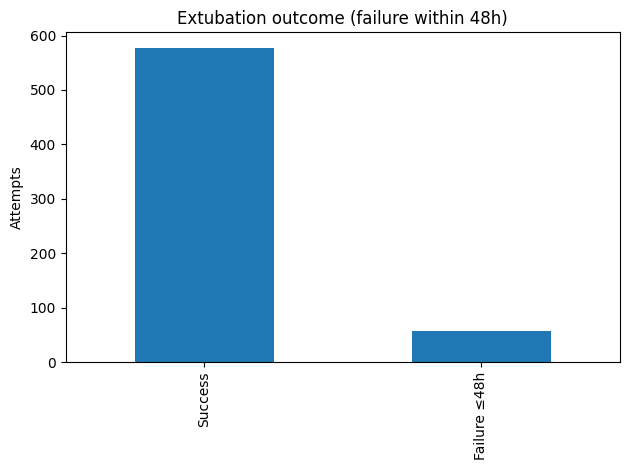

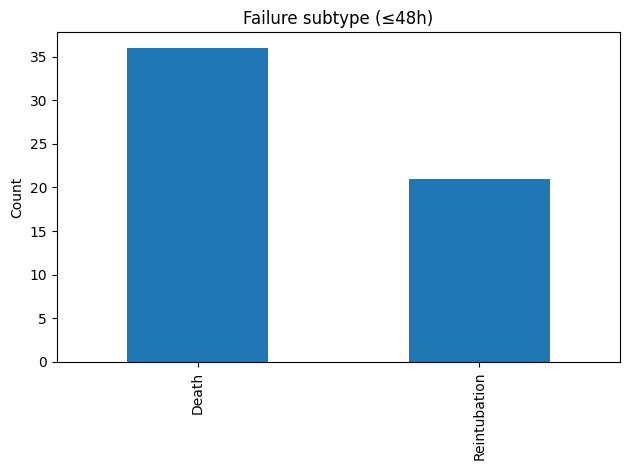

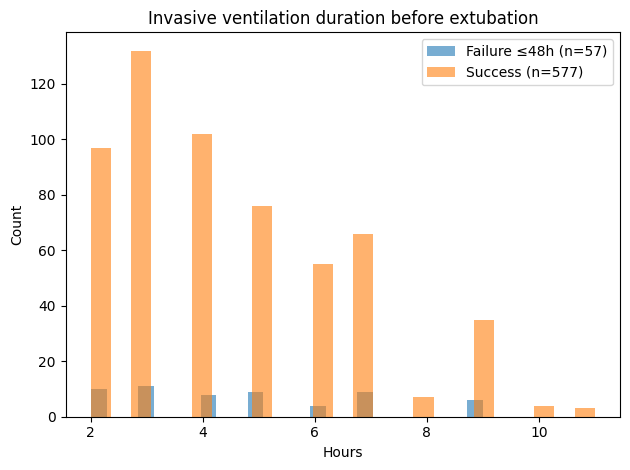

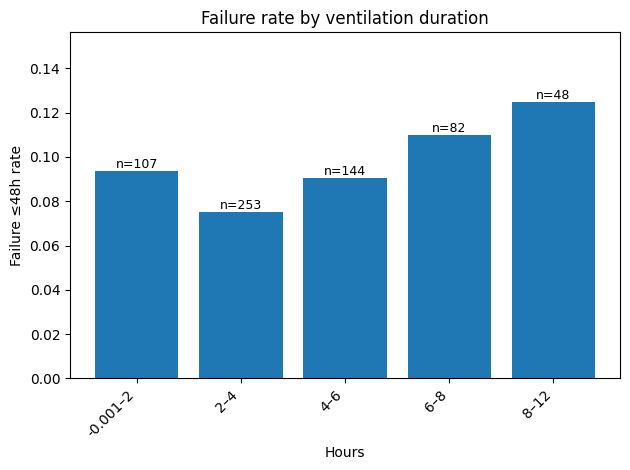

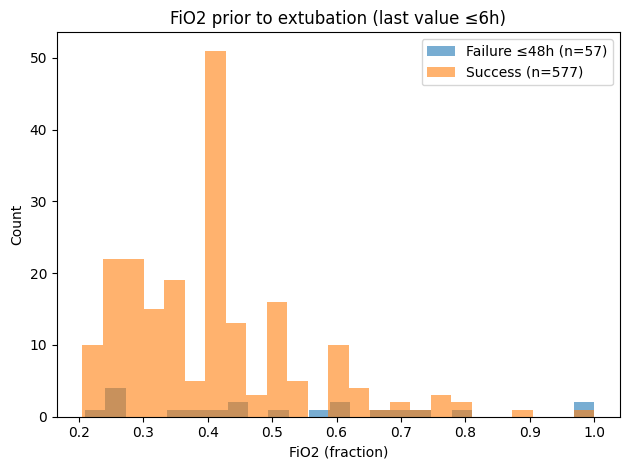

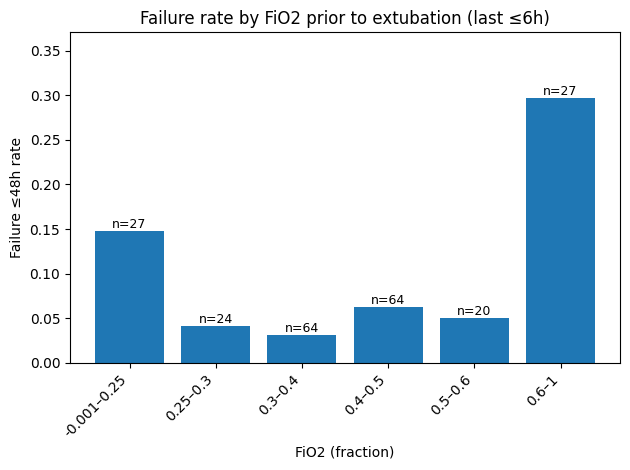

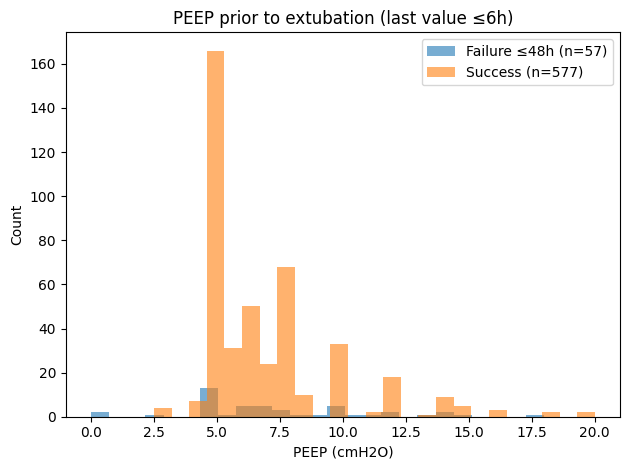

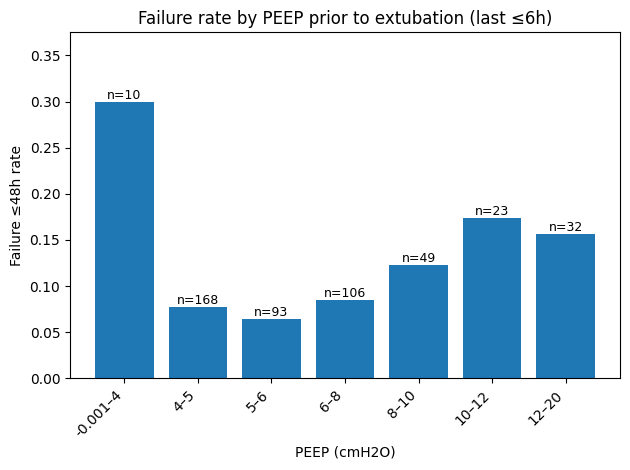

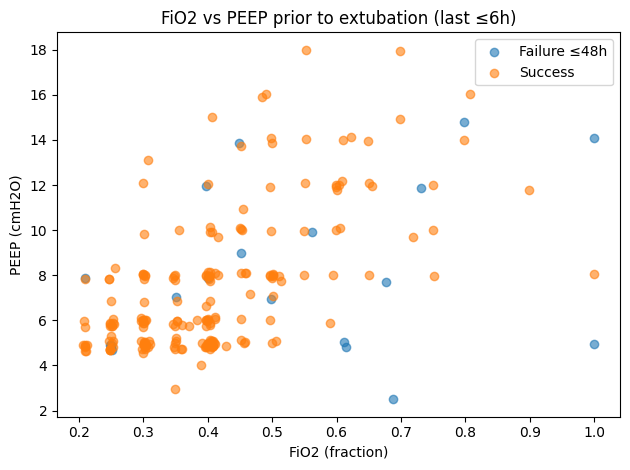

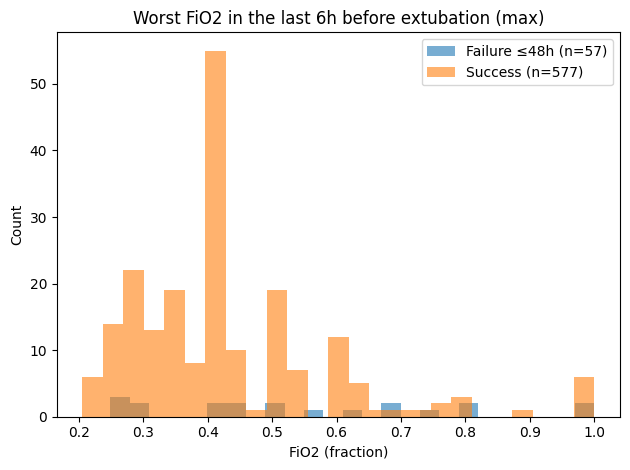

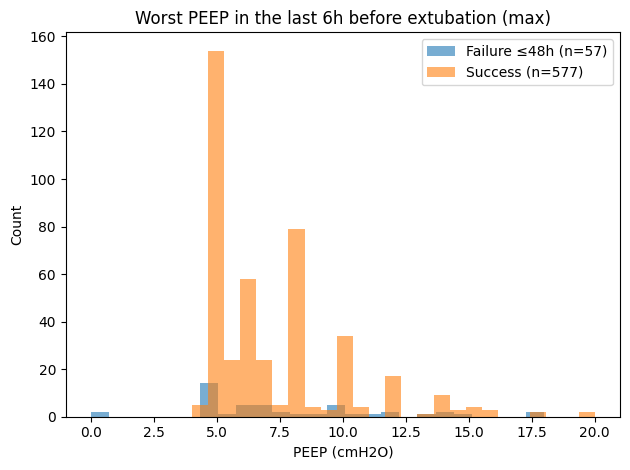

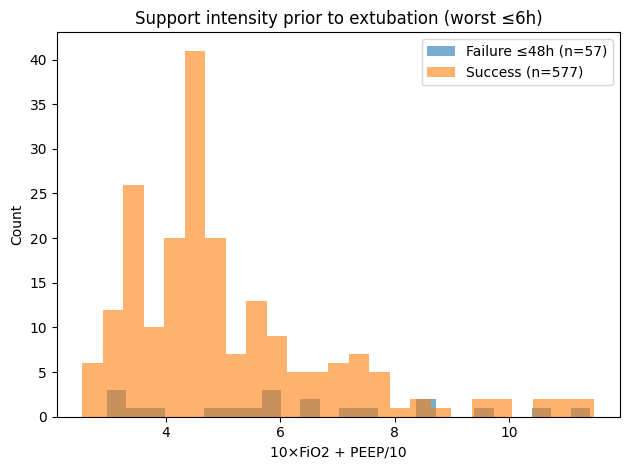

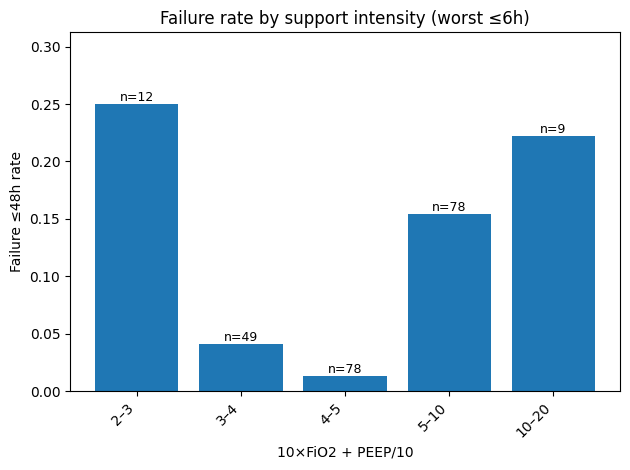

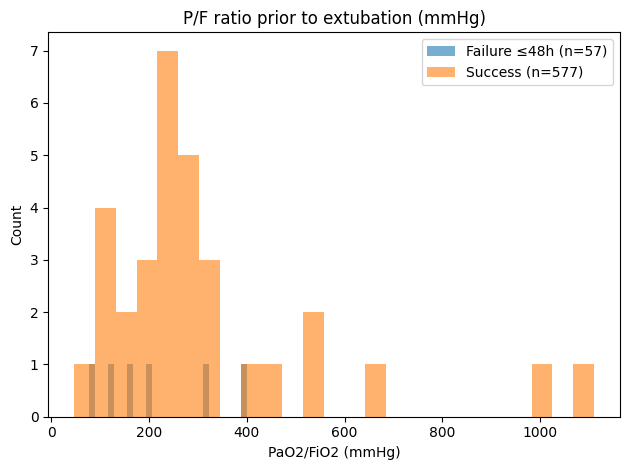

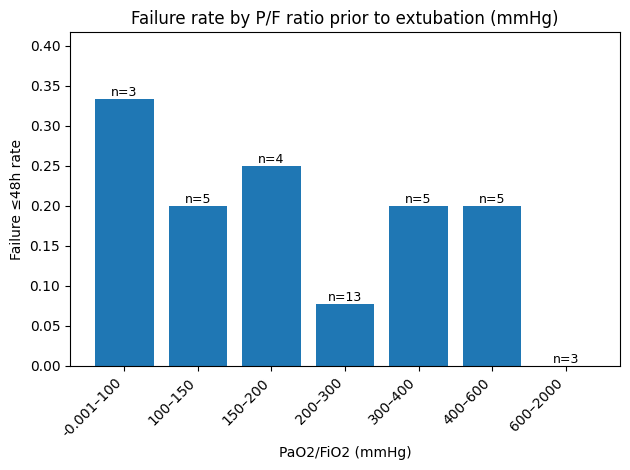

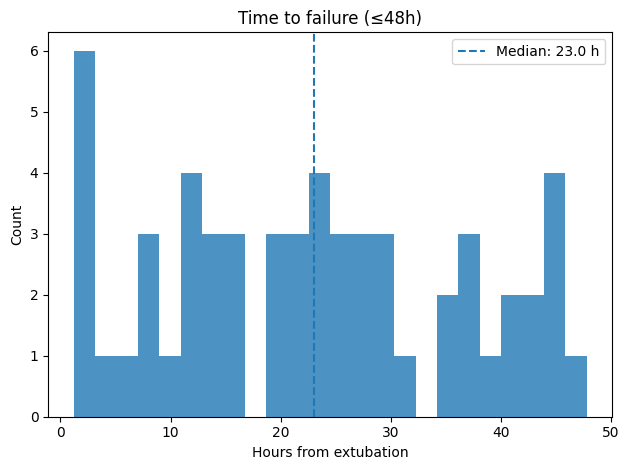

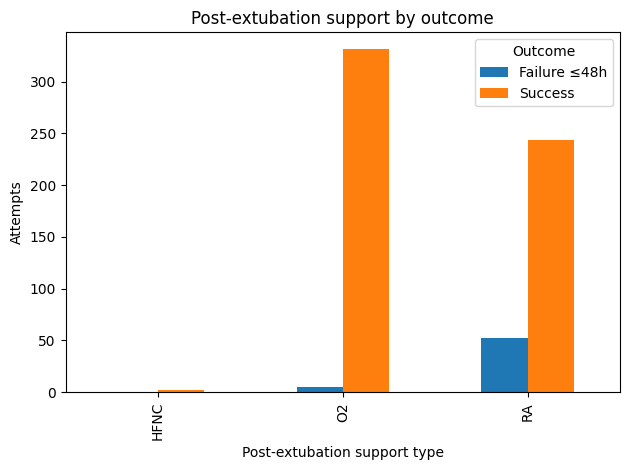

RA = no O2 flow documented / possibly room air


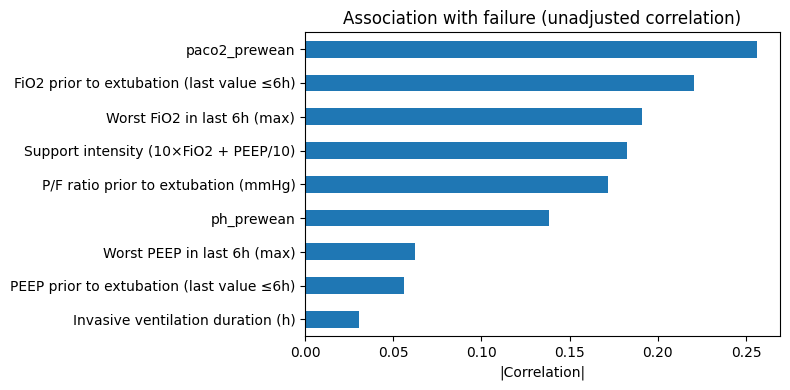


Top associations (unadjusted Pearson correlation):
paco2_prewean                                0.256469
FiO2 prior to extubation (last value ≤6h)    0.220513
Worst FiO2 in last 6h (max)                  0.190866
Support intensity (10×FiO2 + PEEP/10)        0.182638
P/F ratio prior to extubation (mmHg)        -0.171539
ph_prewean                                  -0.138573
Worst PEEP in last 6h (max)                  0.062050
PEEP prior to extubation (last value ≤6h)    0.055839
Invasive ventilation duration (h)            0.030481
Name: failure_48h, dtype: float64


In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = df.copy()

# setup + cleaning
numeric_cols = [
    "duration_h", "n_hours",
    "fio2_mean", "peep_mean", "rr_mean", "tv_mean",
    "pao2_prewean", "paco2_prewean", "ph_prewean", "sao2_prewean",
    "hrs_since_abg_core", "hrs_since_gas_any",
    "time_to_failure_h",
    "fio2_max_6h", "peep_max_6h", "rr_max_6h", "tv_max_6h",
    "fio2_last_6h", "peep_last_6h", "rr_last_6h", "tv_last_6h",
]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Timestamps
for c in ["inv_start", "wean_time", "failure_time"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)

# Outcome labels
df["Outcome"] = np.where(df["failure_48h"] == 1, "Failure ≤48h", "Success")

# Failure subtype
df["Failure type"] = np.select(
    [
        (df.get("reintub_48h", 0) == 1) & (df.get("death_48h", 0) == 0),
        (df.get("death_48h", 0) == 1) & (df.get("reintub_48h", 0) == 0),
        (df.get("reintub_48h", 0) == 1) & (df.get("death_48h", 0) == 1),
    ],
    ["Reintubation", "Death", "Both"],
    default="None",
)

# Vent duration
df["Invasive ventilation duration (h)"] = df["duration_h"].astype(float)

# Settings prior to extubation
df["FiO2 prior to extubation (last value ≤6h)"] = df["fio2_last_6h"].astype(float)
df["PEEP prior to extubation (last value ≤6h)"] = df["peep_last_6h"].astype(float)
df["RR prior to extubation (last value ≤6h)"] = df["rr_last_6h"].astype(float)
df["TV prior to extubation (last value ≤6h)"] = df["tv_last_6h"].astype(float)

df["FiO2 mean during invasive period"] = df["fio2_mean"].astype(float)
df["PEEP mean during invasive period"] = df["peep_mean"].astype(float)
df["RR mean during invasive period"] = df["rr_mean"].astype(float)
df["TV mean during invasive period"] = df["tv_mean"].astype(float)

# Worst (max) settings in last 6h
df["Worst FiO2 in last 6h (max)"] = df["fio2_max_6h"].astype(float)
df["Worst PEEP in last 6h (max)"] = df["peep_max_6h"].astype(float)
df["Worst RR in last 6h (max)"] = df["rr_max_6h"].astype(float)
df["Worst TV in last 6h (max)"] = df["tv_max_6h"].astype(float)

# sA02
sao2 = pd.to_numeric(df.get("sao2_prewean", np.nan), errors="coerce")
sao2_norm = np.where(sao2.notna(), np.where(sao2 > 1.5, sao2 / 100.0, sao2), np.nan)
sao2_norm = np.where((sao2_norm >= 0.3) & (sao2_norm <= 1.0), sao2_norm, np.nan)
df["SaO2 prior to extubation (fraction)"] = sao2_norm.astype(float)

# P/F ratio
KPA_TO_MMHG = 7.50062
df["PaO2 prior to extubation (mmHg)"] = pd.to_numeric(df.get("pao2_prewean", np.nan), errors="coerce").astype(float) * KPA_TO_MMHG
fio2_for_pf = df["Worst FiO2 in last 6h (max)"].astype(float)
df["P/F ratio prior to extubation (mmHg)"] = np.where(
    df["PaO2 prior to extubation (mmHg)"].notna() & fio2_for_pf.notna() & (fio2_for_pf > 0),
    df["PaO2 prior to extubation (mmHg)"] / fio2_for_pf,
    np.nan
)

# Simple support intensity index (using worst settings)
df["Support intensity (10×FiO2 + PEEP/10)"] = np.where(
    df["Worst FiO2 in last 6h (max)"].notna() & df["Worst PEEP in last 6h (max)"].notna(),
    10 * df["Worst FiO2 in last 6h (max)"] + (df["Worst PEEP in last 6h (max)"] / 10.0),
    np.nan
)

# clinical summary
n = len(df)
fail = int(df["failure_48h"].sum())
print(f"Attempts: {n:,}")
print(f"Failure ≤48h: {fail:,} ({(fail/n if n else np.nan):.1%})")
print(f"  Reintubation ≤48h: {float(pd.to_numeric(df.get('reintub_48h', pd.Series([np.nan])), errors='coerce').mean()):.1%}")
print(f"  Death ≤48h: {float(pd.to_numeric(df.get('death_48h', pd.Series([np.nan])), errors='coerce').mean()):.1%}")

if fail:
    tt = pd.to_numeric(df.loc[df["failure_48h"] == 1, "time_to_failure_h"], errors="coerce").dropna()
    if len(tt):
        print(f"Median time to failure: {float(tt.median()):.1f} h (IQR {float(tt.quantile(0.25)):.1f}–{float(tt.quantile(0.75)):.1f})")

# helper
def _series_numeric(s):
    return pd.to_numeric(s, errors="coerce").astype(float)

def describe_by_outcome(col, label=None):
    label = label or col
    g = df.groupby("Outcome")[col]
    out = pd.DataFrame({
        "n": g.size(),
        "median": g.median(),
        "p25": g.quantile(0.25),
        "p75": g.quantile(0.75),
        "mean": g.mean(),
        "missing_%": g.apply(lambda x: x.isna().mean() * 100),
    })
    out.index.name = label
    return out

def plot_hist_by_outcome(col, xlabel, title, bins=30):
    plt.figure()
    for outcome, sub in df.groupby("Outcome"):
        vals = _series_numeric(sub[col]).dropna().values
        if len(vals) == 0:
            continue
        plt.hist(vals, bins=bins, alpha=0.6, label=f"{outcome} (n={len(sub)})")
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_failure_rate_binned(col, bins, xlabel, title):
    tmp = df[[col, "failure_48h"]].copy()
    tmp[col] = _series_numeric(tmp[col])
    tmp = tmp.dropna(subset=[col, "failure_48h"])
    if tmp.empty:
        print(f"[skip] {title}: no data after dropna")
        return
    tmp["bin"] = pd.cut(tmp[col], bins=bins, include_lowest=True)
    rates = tmp.groupby("bin", observed=True)["failure_48h"].mean()
    counts = tmp.groupby("bin", observed=True)["failure_48h"].size()

    plt.figure()
    plt.bar(range(len(rates)), rates.values)
    plt.xticks(range(len(rates)), [f"{b.left:g}–{b.right:g}" for b in rates.index], rotation=45, ha="right")
    plt.ylim(0, max(0.05, min(0.6, float(rates.max()) * 1.25)))
    plt.xlabel(xlabel)
    plt.ylabel("Failure ≤48h rate")
    plt.title(title)
    for i, c in enumerate(counts.values):
        plt.text(i, rates.values[i], f"n={int(c)}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

def plot_scatter(colx, coly, xlabel, ylabel, title):
    plt.figure()
    sub = df[[colx, coly, "Outcome"]].copy()
    sub[colx] = _series_numeric(sub[colx])
    sub[coly] = _series_numeric(sub[coly])
    sub = sub.dropna(subset=[colx, coly])
    for outcome, g in sub.groupby("Outcome"):
        plt.scatter(g[colx].values, g[coly].values, alpha=0.6, label=outcome)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------
print("\nClinical summaries by outcome")
display(describe_by_outcome("Invasive ventilation duration (h)", "Vent duration (hours)"))
display(describe_by_outcome("FiO2 prior to extubation (last value ≤6h)", "FiO2 prior to extubation (last value ≤6h)"))
display(describe_by_outcome("PEEP prior to extubation (last value ≤6h)", "PEEP prior to extubation (last value ≤6h)"))
display(describe_by_outcome("Worst FiO2 in last 6h (max)", "Worst FiO2 (max ≤6h)"))
display(describe_by_outcome("Worst PEEP in last 6h (max)", "Worst PEEP (max ≤6h)"))
display(describe_by_outcome("P/F ratio prior to extubation (mmHg)", "P/F ratio prior to extubation (mmHg)"))
display(describe_by_outcome("Support intensity (10×FiO2 + PEEP/10)", "Support intensity"))

print("\nFailure subtype counts (among failures)")
display(df.loc[df["failure_48h"] == 1, "Failure type"].value_counts(dropna=False))

# Clinical interpretation (single cell)
pf_missing_fail = df.loc[df["Outcome"] == "Failure ≤48h", "P/F ratio prior to extubation (mmHg)"].isna().mean() * 100
pf_missing_succ = df.loc[df["Outcome"] == "Success", "P/F ratio prior to extubation (mmHg)"].isna().mean() * 100
fio2_missing_fail = df.loc[df["Outcome"] == "Failure ≤48h", "Worst FiO2 in last 6h (max)"].isna().mean() * 100
fio2_missing_succ = df.loc[df["Outcome"] == "Success", "Worst FiO2 in last 6h (max)"].isna().mean() * 100

# Outcome
ax = df["Outcome"].value_counts().plot(kind="bar")
ax.set_xlabel("")
ax.set_ylabel("Attempts")
ax.set_title("Extubation outcome (failure within 48h)")
plt.tight_layout()
plt.show()

ax = df.loc[df["failure_48h"] == 1, "Failure type"].value_counts().plot(kind="bar")
ax.set_xlabel("")
ax.set_ylabel("Count")
ax.set_title("Failure subtype (≤48h)")
plt.tight_layout()
plt.show()

# Vent duration
plot_hist_by_outcome(
    "Invasive ventilation duration (h)",
    xlabel="Hours",
    title="Invasive ventilation duration before extubation",
    bins=25
)
plot_failure_rate_binned(
    "Invasive ventilation duration (h)",
    bins=[0, 2, 4, 6, 8, 12, 24, 48, 200],
    xlabel="Hours",
    title="Failure rate by ventilation duration"
)

# Support settings (last ≤6h)
plot_hist_by_outcome(
    "FiO2 prior to extubation (last value ≤6h)",
    xlabel="FiO2 (fraction)",
    title="FiO2 prior to extubation (last value ≤6h)",
    bins=25
)
plot_failure_rate_binned(
    "FiO2 prior to extubation (last value ≤6h)",
    bins=[0, 0.25, 0.30, 0.40, 0.50, 0.60, 1.0],
    xlabel="FiO2 (fraction)",
    title="Failure rate by FiO2 prior to extubation (last ≤6h)"
)

plot_hist_by_outcome(
    "PEEP prior to extubation (last value ≤6h)",
    xlabel="PEEP (cmH2O)",
    title="PEEP prior to extubation (last value ≤6h)",
    bins=25
)
plot_failure_rate_binned(
    "PEEP prior to extubation (last value ≤6h)",
    bins=[0, 4, 5, 6, 8, 10, 12, 20, 60],
    xlabel="PEEP (cmH2O)",
    title="Failure rate by PEEP prior to extubation (last ≤6h)"
)

plot_scatter(
    "FiO2 prior to extubation (last value ≤6h)",
    "PEEP prior to extubation (last value ≤6h)",
    xlabel="FiO2 (fraction)",
    ylabel="PEEP (cmH2O)",
    title="FiO2 vs PEEP prior to extubation (last ≤6h)"
)

# Worst support (max ≤6h)
plot_hist_by_outcome(
    "Worst FiO2 in last 6h (max)",
    xlabel="FiO2 (fraction)",
    title="Worst FiO2 in the last 6h before extubation (max)",
    bins=25
)
plot_hist_by_outcome(
    "Worst PEEP in last 6h (max)",
    xlabel="PEEP (cmH2O)",
    title="Worst PEEP in the last 6h before extubation (max)",
    bins=25
)

plot_hist_by_outcome(
    "Support intensity (10×FiO2 + PEEP/10)",
    xlabel="10×FiO2 + PEEP/10",
    title="Support intensity prior to extubation (worst ≤6h)",
    bins=25
)
plot_failure_rate_binned(
    "Support intensity (10×FiO2 + PEEP/10)",
    bins=[0, 1, 2, 3, 4, 5, 10, 20],
    xlabel="10×FiO2 + PEEP/10",
    title="Failure rate by support intensity (worst ≤6h)"
)

# Oxygenation (P/F)
plot_hist_by_outcome(
    "P/F ratio prior to extubation (mmHg)",
    xlabel="PaO2/FiO2 (mmHg)",
    title="P/F ratio prior to extubation (mmHg)",
    bins=25
)
plot_failure_rate_binned(
    "P/F ratio prior to extubation (mmHg)",
    bins=[0, 100, 150, 200, 300, 400, 600, 2000],
    xlabel="PaO2/FiO2 (mmHg)",
    title="Failure rate by P/F ratio prior to extubation (mmHg)"
)

# Time-to-failure
tt = pd.to_numeric(df.loc[df["failure_48h"] == 1, "time_to_failure_h"], errors="coerce").dropna()
plt.figure()
if len(tt):
    plt.hist(tt.values, bins=24, alpha=0.8)
    plt.axvline(float(tt.median()), linestyle="--", label=f"Median: {float(tt.median()):.1f} h")
    plt.xlabel("Hours from extubation")
    plt.ylabel("Count")
    plt.title("Time to failure (≤48h)")
    plt.legend()
else:
    plt.text(0.5, 0.5, "No time_to_failure_h available", ha="center")
    plt.title("Time to failure (≤48h)")
plt.tight_layout()
plt.show()

# post-extubation support
ax = pd.crosstab(df["post_support"], df["Outcome"]).plot(kind="bar")
ax.set_xlabel("Post-extubation support type")
ax.set_ylabel("Attempts")
ax.set_title("Post-extubation support by outcome")
plt.tight_layout()
plt.show()
print("RA = no O2 flow documented / possibly room air")

# Correlations
candidate_features = [
    "Invasive ventilation duration (h)",
    "FiO2 prior to extubation (last value ≤6h)",
    "PEEP prior to extubation (last value ≤6h)",
    "Worst FiO2 in last 6h (max)",
    "Worst PEEP in last 6h (max)",
    "Support intensity (10×FiO2 + PEEP/10)",
    "P/F ratio prior to extubation (mmHg)",
    "ph_prewean",
    "paco2_prewean",
]
tmp = df[candidate_features + ["failure_48h"]].copy()
for c in candidate_features:
    tmp[c] = pd.to_numeric(tmp[c], errors="coerce")
tmp = tmp.dropna(subset=["failure_48h"])

corr = tmp.corr(numeric_only=True)["failure_48h"].drop("failure_48h").sort_values(
    key=lambda s: s.abs(), ascending=False
)

ax = corr.abs().sort_values().plot(kind="barh", figsize=(8, 4))
ax.set_xlabel("|Correlation|")
ax.set_title("Association with failure (unadjusted correlation)")
plt.tight_layout()
plt.show()

print("\nTop associations (unadjusted Pearson correlation):")
print(corr)

Clinical interpretation
* Failures show higher oxygen support needs before extubation (FiO2 and PEEP) and worse oxygenation where measurable (lower P/F)
* PaCO2 tends to be higher and pH lower in failures, consistent with ventilatory failure risk
* Ventilation duration is similar between groups in this filtered cohort
* Missingness is substantial
* Composite failure is death-heavy in this cohort